In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

from tensorflow import keras

from sklearn.preprocessing import StandardScaler

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.10.0
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.1
pandas 1.4.4
sklearn 1.1.2
tensorflow 2.10.0
keras.api._v2.keras 2.10.0


* 添加高空层次, 特别是逆温的判别
* 自定义损失函数

In [2]:
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  file_dir = "F:/github/pythonScript/seafog/data/collection/"
else:
  file_dir = "H:/github/python/seafog/data/collection/"

In [3]:
def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

In [38]:
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/extend/fog_dataset_extend.hdf"
fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './multi_level/fog_dataset_extend_multilevels.hdf'))
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')

# df_train.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_valid.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_test.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)


# x_columns = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour',]
df_train['t_td'] =  df_train['t2mm'] - df_train['t2md']
df_train['td_sst'] =  df_train['t2md'] - df_train['sstk']
df_train['t_sst'] =  df_train['t2mm'] - df_train['sstk']
df_train['delta_theta'] = df_train['theta925'] - df_train['theta1000']
df_train['delta_theta_e'] = df_train['theta_e925'] - df_train['theta_e1000']

df_valid['t_td']   =  df_valid['t2mm'] - df_valid['t2md']
df_valid['td_sst'] =  df_valid['t2md'] - df_valid['sstk']
df_valid['t_sst']  =  df_valid['t2mm'] - df_valid['sstk']
df_valid['delta_theta'] = df_valid['theta925'] - df_valid['theta1000']
df_valid['delta_theta_e'] = df_valid['theta_e925'] - df_valid['theta_e1000']

df_test['t_td']   =  df_test['t2mm'] - df_test['t2md']
df_test['td_sst'] =  df_test['t2md'] - df_test['sstk']
df_test['t_sst']  =  df_test['t2mm'] - df_test['sstk']
df_test['delta_theta'] = df_test['theta925'] - df_test['theta1000']
df_test['delta_theta_e'] = df_test['theta_e925'] - df_test['theta_e1000']

x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour','delta_theta','delta_theta_e','theta_e925']

df_train_x = df_train.loc[:, x_columns]
df_train_y = df_train['station_vis_linear']

df_valid_x = df_valid.loc[:, x_columns]
df_valid_y = df_valid['station_vis_linear']

df_test_x = df_test.loc[:, x_columns]
df_test_y = df_test['station_vis_linear']

train_x = df_train_x.to_numpy()
train_y = df_train_y.to_numpy()

valid_x = df_valid_x.to_numpy()
valid_y = df_valid_y.to_numpy()

test_x = df_test_x.to_numpy()
test_y = df_test_y.to_numpy()

print(train_x.shape)
print(train_y.shape)

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled  = scaler.transform(test_x)
valid_x_scaled = scaler.fit_transform(valid_x)


keep_cols = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e'] # 不需要标准化变量的参数

for iColumn in keep_cols:
    index = x_columns.index(iColumn)
    train_x_scaled[:,index] = train_x[:,index]
    valid_x_scaled[:,index] = valid_x[:,index]
    test_x_scaled[:,index]  = test_x[:,index]

# train_x_scaled[:,0:3] = train_x[:,0:3]
# train_x_scaled[:,-5:-1] = train_x[:,-5:-1]
# valid_x_scaled[:,0:3]   = valid_x[:,0:3]
# valid_x_scaled[:,-5:-1] = valid_x[:,-5:-1]
# test_x_scaled[:,0:3]    = test_x[:,0:3]
# test_x_scaled[:,-5:-1]  = test_x[:,-5:-1]


['/test', '/train', '/valid']
(63215, 18)
(63215,)


In [12]:
print(np.max(train_x_scaled[:,-5]), np.min(train_x_scaled[:,-5]))

1.0 -1.0


In [13]:
train_x[:,0:3]

array([[ 1.73995972, -1.26571655,  0.47424316],
       [ 3.21112061, -4.43765259, -1.22653198],
       [ 1.92358398, -2.21136475, -0.28778076],
       ...,
       [ 1.53057861, -2.48498535, -0.95440674],
       [ 1.39678955, -1.41278076, -0.01599121],
       [ 2.14892578, -2.7454834 , -0.59655762]])

In [32]:
# tf.keras.models.Sequential()

"""
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
"""

model = keras.models.Sequential([
    keras.layers.Dense(40, activation='relu',
                       input_shape=train_x_scaled.shape[1:]),                 
    keras.layers.Dense(18, activation='relu'),
    keras.layers.Dense(1),
])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss="mean_squared_error", optimizer="sgd")

In [90]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 30)                480       
_________________________________________________________________
dense_29 (Dense)             (None, 6)                 186       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 7         
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________


In [33]:
# H:/github/python/seafog/
logdir = './callbacks_reg_pressure'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "sea_fog_reg_model.h5")

model_callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    keras.callbacks.EarlyStopping(patience=8, min_delta=1e-4),
    ]
history = model.fit(train_x_scaled, train_y, epochs=50,
                    validation_data=(valid_x_scaled, valid_y),
                    callbacks = model_callbacks)

Epoch 1/50
1976/1976 [==============================] - 5s 2ms/step - loss: 0.2459 - val_loss: 0.2178
Epoch 2/50
1976/1976 [==============================] - 5s 2ms/step - loss: 0.1933 - val_loss: 0.2024
Epoch 3/50
1976/1976 [==============================] - 5s 2ms/step - loss: 0.1784 - val_loss: 0.1874
Epoch 4/50
1976/1976 [==============================] - 5s 2ms/step - loss: 0.1692 - val_loss: 0.1906
Epoch 5/50
1976/1976 [==============================] - 5s 2ms/step - loss: 0.1624 - val_loss: 0.1767
Epoch 6/50
1976/1976 [==============================] - 5s 2ms/step - loss: 0.1575 - val_loss: 0.1691
Epoch 7/50
1976/1976 [==============================] - 4s 2ms/step - loss: 0.1536 - val_loss: 0.1733
Epoch 8/50
1976/1976 [==============================] - 5s 2ms/step - loss: 0.1499 - val_loss: 0.1659
Epoch 9/50
1976/1976 [==============================] - 4s 2ms/step - loss: 0.1475 - val_loss: 0.1687
Epoch 10/50
1976/1976 [==============================] - 4s 2ms/step - loss: 0.144

In [17]:
type(history)

keras.callbacks.History

In [18]:
history.history

{'loss': [0.24813565611839294,
  0.1992785930633545,
  0.18755654990673065,
  0.18192432820796967,
  0.17792129516601562,
  0.17425332963466644,
  0.17115217447280884,
  0.16807934641838074,
  0.16565148532390594,
  0.16319076716899872,
  0.1605566143989563,
  0.1590292900800705,
  0.1573318988084793,
  0.15526707470417023,
  0.15352480113506317,
  0.15165133774280548,
  0.15030604600906372,
  0.1482602059841156,
  0.14725106954574585,
  0.14621353149414062,
  0.14479795098304749,
  0.14368803799152374,
  0.1424335241317749,
  0.1414341926574707,
  0.14015448093414307,
  0.13927026093006134,
  0.13897018134593964,
  0.13767041265964508,
  0.1370810866355896,
  0.1363859623670578,
  0.13598017394542694,
  0.13492482900619507,
  0.13466805219650269,
  0.13390521705150604,
  0.13337749242782593,
  0.13313977420330048,
  0.13297194242477417,
  0.1324610412120819,
  0.13174881041049957,
  0.13096724450588226,
  0.13066808879375458,
  0.13085278868675232,
  0.12970781326293945,
  0.129789277

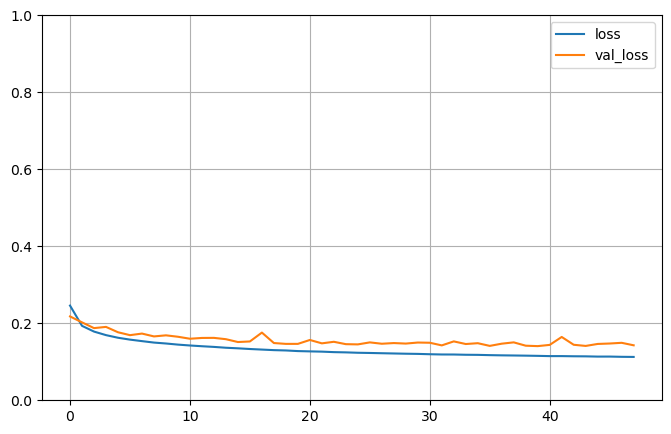

In [34]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

0.2715427875518799

* 默认方法MSE 在0.36左右，关键因素是温度和日期
* 添加t-td 等函数后，MSE 在0.3

In [36]:

predictions

array([[0.35056606],
       [0.37090513],
       [0.42883396],
       ...,
       [2.323665  ],
       [2.64585   ],
       [1.974982  ]], dtype=float32)

测试集均方差0.2652359902858734


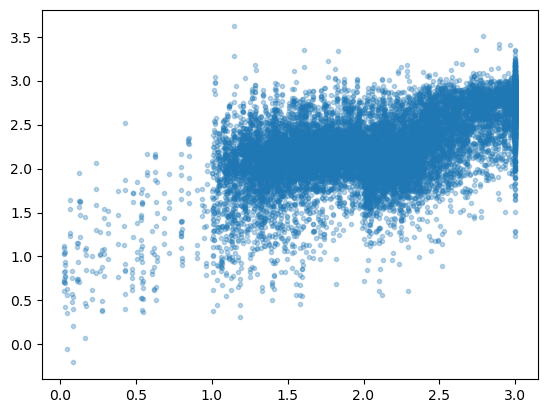

In [40]:
test_mse = model.evaluate(test_x_scaled, test_y, verbose=0)
print(f'测试集均方差{test_mse}')
predictions = model(test_x_scaled).numpy()
plt.plot(test_y, predictions,'.', alpha=0.3)
plt.show()

In [41]:
r,p = pearsonr(predictions[:,0],test_y)
print(f'相关系数{r}, p值为{p:.5f}')

相关系数0.6043034834000474, p值为0.00000


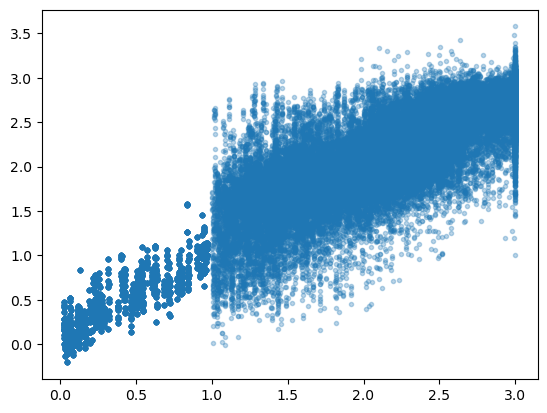

In [42]:
plt.plot(train_y,model(train_x_scaled).numpy(),'.', alpha=0.3)
plt.show()

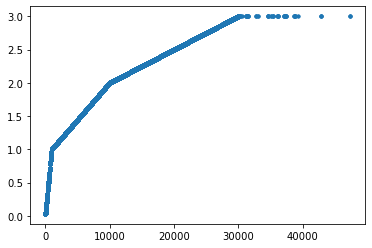

In [17]:
plt.plot(df_train['station_vis'].values,train_y,'.')
plt.show()

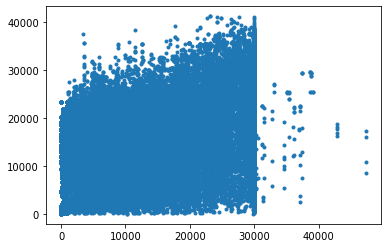

In [55]:
plt.plot(df_train['station_vis'].values,df_train['visi'],'.')
plt.show()

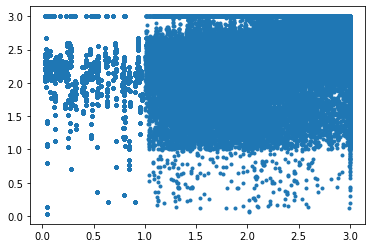

1.2369055392943231


In [100]:
plt.plot(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis),'.')
plt.show()
print(mean_squared_error(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis)))

In [ ]:
p_test = tf.nn.softmax(predictions).numpy()

In [ ]:
p_test[:,0]

In [ ]:
df_p_test = pd.DataFrame({'p_fog':p_test[:,0],'p_mist':p_test[:,1],'p_clear':p_test[:,2]})

In [ ]:
df_p_test['p_clear'].plot()
df_p_test['p_mist'].plot()
df_p_test['p_fog'].plot()

In [ ]:

df_test_result = df_test.join(df_p_test) 
print(df_test_result.head())
df_test_result.to_csv('df_test_result.csv')

In [ ]:
# 各类别预测准确性对比
# 筛选出不同类别 df_all.loc[df_all['station_vis_cat'] == 2]
# 计算输出的类别 